In [1]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [3]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype("float32") / 255
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [4]:
input_shape = (image_size, image_size, 1)
batch_size = 32
latent_dim = 16

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69008 (269.56 KB)
Trainable params: 69008 (269.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


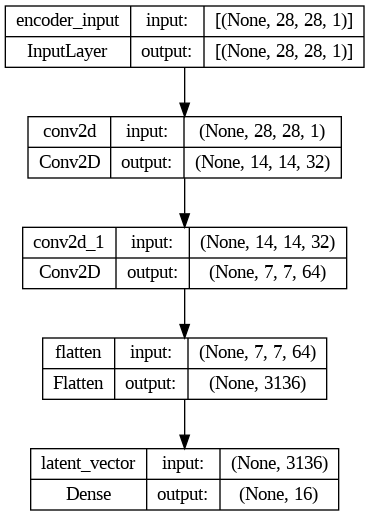

In [6]:
# Step-1 encoder model
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

x = Conv2D(filters = 32, kernel_size = 3, activation = "relu", strides = 2, padding = 'same')(x)
x = Conv2D(filters = 64, kernel_size = 3, activation = "relu", strides = 2, padding = "same")(x)

shape = K.int_shape(x)

x = Flatten()(x)
latent = Dense(latent_dim, name = "latent_vector")(x)

encoder = Model(inputs, latent, name = "encoder")

encoder.summary()
plot_model(encoder, show_shapes = True)

In [13]:
shape

(None, 7, 7, 64)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense_3 (Dense)             (None, 3136)              53312     
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289 

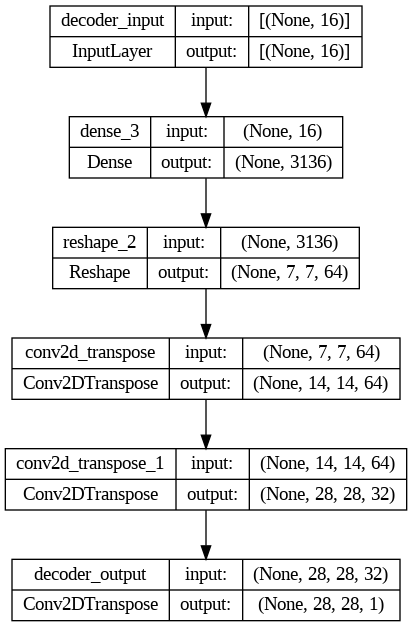

In [12]:
# Step - 2 decoder model
latent_inputs = Input(shape = (latent_dim,), name = 'decoder_input')

x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(filters = 64, kernel_size = 3, activation = "relu", strides = 2, padding = "same")(x)
x = Conv2DTranspose(filters = 32, kernel_size = 3, activation = "relu", strides = 2, padding = "same")(x)

outputs = Conv2DTranspose(filters = 1, kernel_size = 3, activation = "sigmoid", padding = "same", name = "decoder_output")(x)

decoder = Model(latent_inputs, outputs, name = "decoder")
decoder.summary()
plot_model(decoder, show_shapes = True)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178001 (695.32 KB)
Trainable params: 178001 (695.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


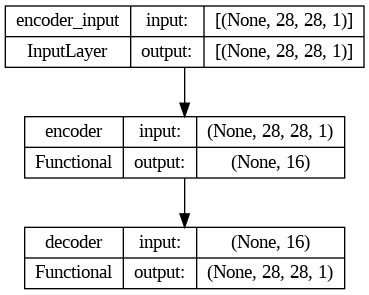

In [14]:
# Step - 3 Autoencoder
autoencoder = Model(inputs, decoder(encoder(inputs)), name = "autoencoder")
autoencoder.summary()
plot_model(autoencoder, show_shapes = True)

In [16]:
# compile and train the model
autoencoder.compile(loss = "mse", optimizer = "adam")
autoencoder.fit(x_train, x_train, validation_data = (x_test, x_test), epochs = 1, batch_size = batch_size)

x_decoded = autoencoder.predict(x_test)

313/313 [==============================] - 7s 21ms/step


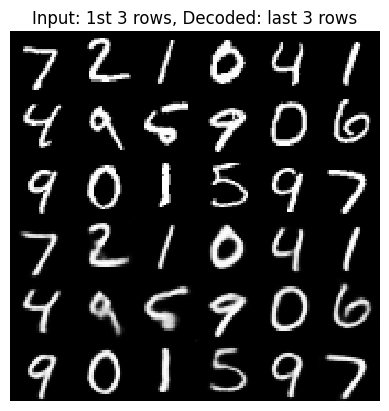

In [21]:
imgs = np.concatenate([x_test[:18], x_decoded[:18]])
imgs = imgs.reshape((6, 6, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 3 rows, Decoded: last 3 rows')
plt.imshow(imgs, interpolation = "none", cmap = "gray")
plt.show()